#Machine Learning Estadístico para Interfaces Cerebro-Computadora

## Trabajo Práctico de Laboratorio de Computación III - Parte II: LDA regularizado y máquinas de soporte vectorial


❗Antes de comenzar recordá hacer una copia de este documento de manera que puedas editarlo y guardar los cambios en tu Drive.

Este TPLC tiene como objetivo que el alumno sea capaz de:
1. Comprender el impacto de la estimación de las matrices de covarianza
2. Aprender del uso de regularizadores para mejorar la estabilidad en la solución
3. Comprender la diferencia entre parámetros e hiperparámetros de un modelo
4. Entender la importancia de la normalización de los datos y búsqueda de hiperparámetros

Es **requisito** para aprobar este curso que esta guía práctica sea completada y enviada para su evaluación. Se aceptan trabajos realizados en forma grupal de *hasta dos alumnos por grupo*.

In [1]:
# instalamos MNE
!pip install MNE


[notice] A new release of pip available: 22.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Importamos las bibliotecas y funciones
import numpy as np
import matplotlib.pyplot as plt
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne import Epochs, pick_types, events_from_annotations
import mne

# Los datos

Vamos a trabajar con los datos de ERPs que trabajamos en el [TPLC_1](https://colab.research.google.com/drive/15yhfPmb-RJ_WFVysAxeKIpxp0Yn7UqJC?authuser=1#scrollTo=JVpoinhE3nNN).

Enfocandonos en el problema de detección, nos vamos a centrar en poder discriminar entre épocas de estimulación izquierda visual vs. épocas de estimulación izquierda auditiva. En otras palabras, vamos a querer discriminar entre el tipo de estimulación: visual o auditiva.

In [3]:
root = mne.datasets.sample.data_path() / "MEG" / "sample"
raw_file = root / "sample_audvis_raw.fif"
raw_erps = mne.io.read_raw_fif(raw_file, preload=True)

events_file = root / "sample_audvis_raw-eve.fif"
events_erps = mne.read_events(events_file)

Opening raw data file C:\Users\felip\mne_data\MNE-sample-data\MEG\sample\sample_audvis_raw.fif...


    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...


In [4]:
# sampling freq
sfreq = raw_erps.info["sfreq"]
print(sfreq)

600.614990234375


Las señales de ERPs son observadas en la bajas frecuencias (1-12 Hz). Es por esto que para reduccir la dimensionalidad del problema, luego de filtrar los datos, vamos a submuestrear tomando cada 16 muestras.

In [5]:
# raw_highpass_downsampled = raw.copy().resample(sfreq=200) #esto no va

❓ ¿Cuál es la frecuencia final de muestreo?

...

In [6]:
# events of relevant classes
event_erps_dict = {
    "auditory/left": 1,
    "visual/left": 3,
}

#filtro
raw_erps_filt = raw_erps.copy().filter(l_freq=1, h_freq=12)
# epocas
epochs_erp = mne.Epochs(raw_erps_filt, events_erps, event_id=event_erps_dict,
                        baseline=None, tmin=0, tmax=1, picks="eeg",
                        reject=None, proj=False, reject_by_annotation=False,
                        flat=None, preload=True, decim=16)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 1983 samples (3.302 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Not setting metadata
145 matching events found
No baseline correction applied


[Parallel(n_jobs=1)]: Done 366 out of 366 | elapsed:    2.6s finished


Using data from preloaded Raw for 145 events and 602 original time points (prior to decimation) ...
0 bad epochs dropped


Separamos en datos y etiquetas y comprobamos la cantidad de elementos de cada clase:

In [7]:
# Get data and labels
labels = epochs_erp.events[:, -1]
data = epochs_erp.get_data()
print(np.shape(data))
print(sum(labels==1))

(145, 60, 38)
72


👌 OK ahora que tenemos los datos nos surmegimos 🏊 en esta prática

# Matrices de covarianza y LDA

LDA es una método de transformación lineal que depende de la estimación de matrices de covarianza. Se basa en tres supociones generales de los datos:

1. Las features de cada clase tienen distribución Gaussiana.
2. Las distribuciones Gaussianas de todas las clases tienen la misma matriz de covarianza.
3. La distribución verdadera de la clase es conocida.

Mientras que 3 es imposible en la practica, los supuestos 1 y 2 pueden comprobarse con nuestros datos. En particular, es el supuesto dos el que hará que nuestras features sean linealmente separables.

En el conjunto de datos, podemos verificar el supuesto 2 inspeccionando las topografías de los componentes principales correspondientes a los mayores autovalores de las matrices de covarianza para cada clase... veamos 👀




Comenzamos partiendo nuestros datos en training y testing sets 👇

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42, stratify=labels)

Definimos una función para calcular las matrices de covarianza

In [9]:
from sklearn.covariance import EmpiricalCovariance

def compute_covariance_matrices(X, y):
  classes =  np.unique(y)
  covs = []
  sample_weights = []
  for this_class in classes:
    x_class = X[y == this_class]

    cov = sum(EmpiricalCovariance().fit(this_X.T).covariance_ for this_X in x_class)
    cov /= len(x_class)
    covs.append(cov)
  return np.stack(covs)

Y la usamos en los datos de entrenamiento 😄

In [10]:
covs = compute_covariance_matrices(X_train, y_train)
print(np.shape(covs))

(2, 60, 60)


👍 Bien, tenemos nuestras matrices de covarianza. Ahora vamos a aplicar PCA a cada matriz de covarianza y graficar el mapa topográfico de los primeros 4 componentes

In [11]:
from sklearn.decomposition import PCA

pca1 = PCA().fit(covs[0])
wpca1 = pca1.components_

pca2 = PCA().fit(covs[1])
wpca2 = pca2.components_

print(np.shape(wpca1))

(60, 60)


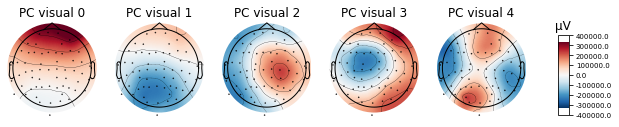

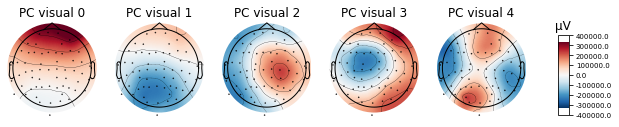

In [12]:
aux_info = epochs_erp.copy().resample(1).info  # make it 1Hz for plotting

# create an evoked
patterns = mne.EvokedArray(wpca1.T, aux_info, tmin=0)
# plot the first 4 components
components = np.arange(5)
patterns.plot_topomap(
            times=components,
            time_format="PC visual %d")

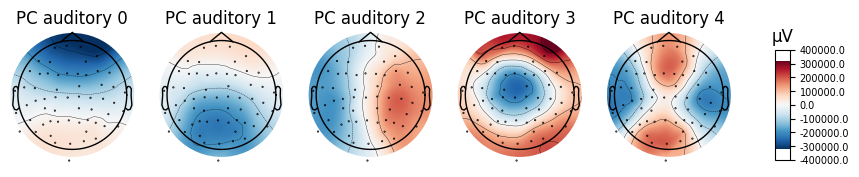

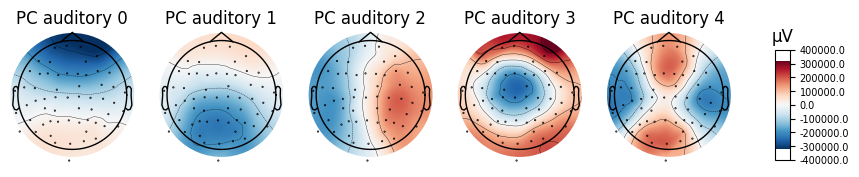

In [13]:
aux_info = epochs_erp.copy().resample(1).info  # make it 1Hz for plotting

# create an evoked
patterns = mne.EvokedArray(wpca2.T, aux_info, tmin=0)
# plot the first 4 components
components = np.arange(5)
patterns.plot_topomap(
            times=components,
            time_format="PC auditory %d")

❓ ¿Qué observas? ¿Se parecen (en morfología) los mapas topográficos? ¿Qué significa esto?

....

❓ ¿Se observará el mismo efecto si sólo usamos el 10% para entrenar?

Para responder esto, hace un código para observar el efecto del tamaño de la muestra en la estimación de la matrices de covarianza.

💡 TIP: podes hacerlo cambiando el `test_size` de la función `train_test_split` que usamos arriba

(2, 60, 60)


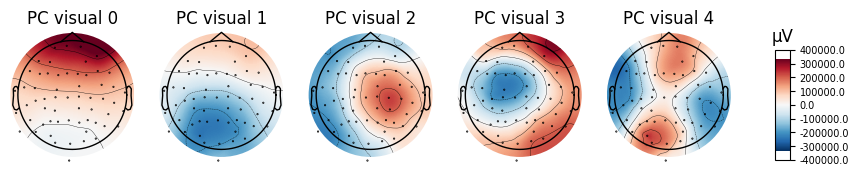

(14, 60, 38)

In [14]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(data, labels, test_size=0.9, random_state=42, stratify=labels)

covs2 = compute_covariance_matrices(X_train, y_train)
print(np.shape(covs2))

pca12 = PCA().fit(covs2[0])
wpca12 = pca12.components_

pca22 = PCA().fit(covs2[1])
wpca22 = pca22.components_


# aux_info = epochs_erp.copy().resample(1).info  # make it 1Hz for plotting

# create an evoked
patterns2 = mne.EvokedArray(wpca12.T, aux_info, tmin=0)
# plot the first 4 components
components = np.arange(5)
patterns2.plot_topomap(
            times=components,
            time_format="PC visual %d")
            
np.shape(X_train2)

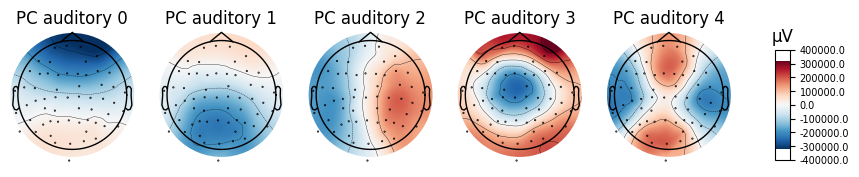

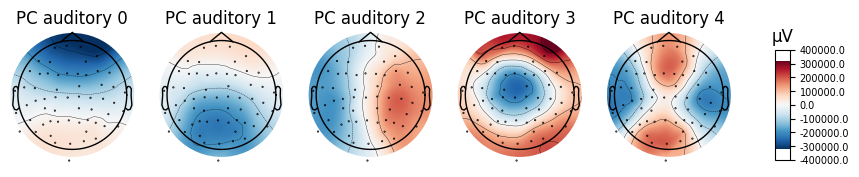

In [15]:
aux_info = epochs_erp.copy().resample(1).info  # make it 1Hz for plotting

# create an evoked
patterns2 = mne.EvokedArray(wpca22.T, aux_info, tmin=0)
# plot the first 4 components
components = np.arange(5)
patterns2.plot_topomap(
            times=components,
            time_format="PC auditory %d")

🏃 🔥 OK la cosa ya no se ve taaan bonita ¿Qué hacemos? Acordate, llorar y salir corriendo nunca es la (única) solución. Veamos que tenemos a mano....

## Shrinkage LDA

El estimador estándar para una matriz de covarianza es la covarianza empírica dada por:

$$\hat{\Sigma} = \frac{1}{n-1}\sum_{i}XX^T,$$

si $X$ tiene media cero.

Este estimador es insesgado (por el $n-1$) y tiene buenas propiedades bajo condiciones usuales. Pero para datos de alta dimensionalidad ($p ≫ N_t$) y/o un número pequeño de datos, la estimación puede volverse imprecisa.

Esto conlleva a un error sistemático: los autovalores grandes de la matriz de covarianza original se estiman demasiado grandes, y los autovalores pequeños se estiman demasiado pequeños, provocando cierta inestabilidad en la solución.

Para contrarrestar el error de estimación, $\hat{\Sigma}$ se reemplaza por $\tilde{Σ}= (1- λ) \hat{Σ} + \lambda \nu I, $ donde $\lambda \in [0, 1]$ es lo que se denomina parámetro de regularización y **$\nu=trace(\hat{Σ})/Nc$ denota el valor promedio de los autovalores**

## 🤝 Manos a la obra

Para comprender el efecto que tiene el parámetro de shrinkage, te vamos a pedir que calcules el score para $λ=0.001, 0.005, 0.05, 0.01, 0.5, 1$. Graficá la performance del clasificador para cada valor de $λ$ estudiado e indicá el valor en el cuál la performance parece ser la mejor.

⚠ Vas a tener que seleccionar canales para el análisis. Alguno canales relevantes para estudiar la presencia de ERPs son Fz, C3, Cz, C4, P3, Pz, P4, PO7, PO8,Oz. Elegí canales que correspondan a esas posiciones.

💡 TIPs:
1. Mirá a la función [`LinearDiscriminantAnalysis`](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis) y jugá con el parámetro `shrinkage`. Recordá poner como solver `eigen`.
2. Para seleccionar canales mirá la función [pick_channels](https://mne.tools/stable/generated/mne.pick_channels.html) de MNE observando según lo que vimos en el [TPLC_1](https://colab.research.google.com/drive/15yhfPmb-RJ_WFVysAxeKIpxp0Yn7UqJC?authuser=1#scrollTo=JVpoinhE3nNN) las posiciones de los canales para esta base datos.

In [16]:
# select the following channels Fz, C3, Cz, C4, P3, Pz, P4, PO7, PO8,Oz
ch2pick = ['EEG 012', 'EEG 028', 'EEG 030', 'EEG 032', 'EEG 047', 'EEG 048', 'EEG 049', 'EEG 044', 'EEG 055', 'EEG 058']

ixd_ch = mne.pick_channels(epochs_erp.info["ch_names"], include=ch2pick)

print(ixd_ch)

[11 27 29 31 43 46 47 48 54 57]


C:\Users\felip\AppData\Local\Temp\ipykernel_19472\2332100877.py:4: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  ixd_ch = mne.pick_channels(epochs_erp.info["ch_names"], include=ch2pick)


In [17]:
# get gata from those ch
X_train_ch = X_train[:,ixd_ch,:]
X_test_ch = X_test[:,ixd_ch,:]

In [18]:
# reshape
nt, nc, ns = np.shape(X_train_ch)
X_tr_lda = X_train_ch.reshape(nt, nc*ns)

nt, nc, ns = np.shape(X_test_ch)
X_test_lda = X_test_ch.reshape(nt, nc*ns)

In [19]:
# import from sklearn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [20]:
lda = LinearDiscriminantAnalysis(solver='eigen', n_components=1, shrinkage= None)
lda.fit(X_tr_lda, y_train)

LinAlgError: The leading minor of order 101 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.

In [21]:
scores = []
for l in [0.001, 0.005, 0.05, 0.01, 0.5, 1]:
  lda = LinearDiscriminantAnalysis(solver='eigen', n_components=1, shrinkage=l)
  lda.fit(X_tr_lda, y_train)
  scores.append(lda.score(X_test_lda, y_test))

scores

[0.9318181818181818,
 0.9318181818181818,
 0.9318181818181818,
 0.9318181818181818,
 0.9545454545454546,
 0.9318181818181818]

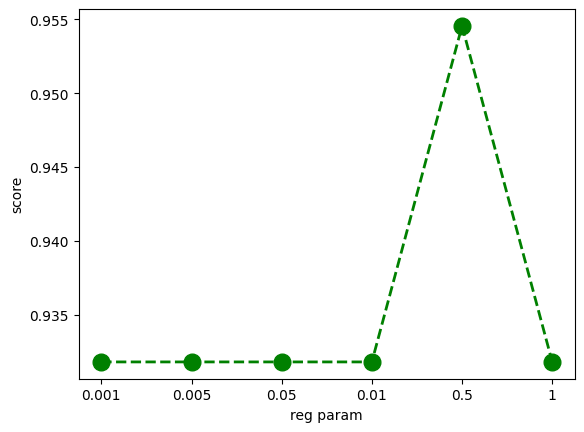

In [22]:
plt.plot(scores, color='green', marker='o', linestyle='dashed',
     linewidth=2, markersize=12)
plt.xticks(range(len([0.001, 0.005, 0.05, 0.01, 0.5, 1])), ([0.001, 0.005, 0.05, 0.01, 0.5, 1]))
plt.xlabel("reg param")
plt.ylabel("score")

❓ ¿Existe una dependencia entre el valor del parámetro de regularización y la performance en clasificación?

....

❓ ¿Qué pasa si entrenas el LDA con estos datos con el parámetros `shrinkage` igual a  `None` ?  ¿Qué ocurre? Probalo 👇

In [ ]:
# escribí tú código acá

#### Búsqueda del mejor parámetro de regularización

El parámetro de regularización en Shrinkage LDA forma parte de lo que denominamos hiperparámetros de nuestros modelos. Es decir, son aquellos parámetros que no forman parte del proceso de aprenzaje (ajuste) pero que definen al modelo en sí mismo. Es por esto que es muy importante poder hallar el mejor hiperparámetro antes de comenzar el proceso de ajuste en sí mismo

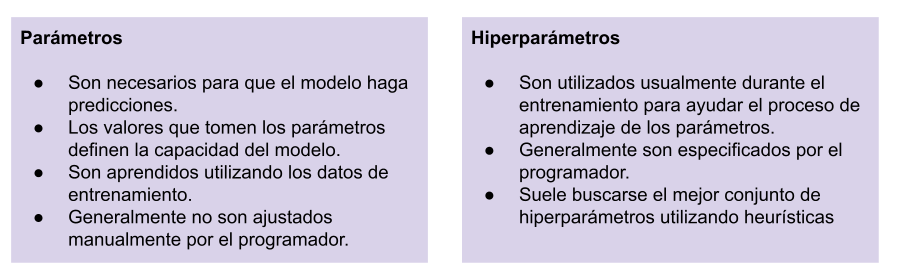

Existen diferentes formas de realizar esta búsqueda. Una de las más conocidas es la búsqueda por grilla, en la cuál dado un conjunto de posibles valores del hiperparámetro evalúo la performance del clasificador en un conjunto de validación.

#### Validación cruzada

La validación cruzada nos permite evaluar el comportamiento de un modelo simulando que parte de nuestros datos de entrenamiento son de testeo. En este sentido, podemos particionar los datos de entrenamiento en lo que se denomina conjunto de **entrenamiento** y **validación**.


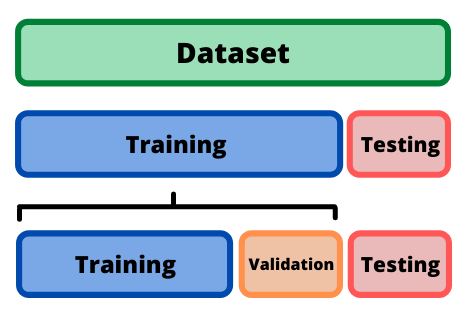

En sklearn podemos utilizar la función [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) para iterar sobre las particiones.

En particular, vamos a definir la grilla de valores, utilizando un rango de valores posibles en escala logarítimica:

In [ ]:
reg = np.logspace(-3, 0, num=20)
print(reg)

Ayudanos complentando el siguiente código en el cuál estamos realizando la búsqueda del mejor parámetro de regularización mediante validación cruzada 👇

In [ ]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5)
scores_all = []
for l in reg:
  scores = []
  for i, (train_index, test_index) in enumerate(cv.split(X_tr_lda, y_train)):
    lda = ....
    ....
    scores.append(lda.score(X_tr_lda[test_index], y_train[test_index]))
  scores_all.append(np.mean(scores))

In [ ]:
plt.plot(scores_all, color='green', marker='o', linestyle='dashed',
     linewidth=2, markersize=12);
plt.xticks(range(len(reg)), np.round(reg,3), rotation = 45);
plt.xlabel("reg param");
plt.ylabel("score");

❓ ¿Por qué en el código tomamos el promedio de los scores?

....

❓ ¿Cuál es el valor optimo del parámetro de regularización? Hallalo 👇

In [ ]:
# escribí tú código acá

Una vez que hemos seleccionado el parámetro de regularización óptimo podemos entonces ajustar mi modelo de clasificación utilizando *ese* valor del parámetro de regularización con todos mis datos de entrenamiento, y finalmente evaluar la performance en mis datos de testeo 🙂.

Hacelo 👇

In [ ]:
lda = ....

print(lda.score(X_test_lda, y_test))

🌟 Voilá, anda SUPER bien nuestro detector de ERPs visuales y auditivos!

❓ ¿El valor del parámetro de regularización hallado será el mismo para otra base de datos, sujetos, o problema de clasificación? ¿ Habría sido el mismo si en vez de querer detectar estímulo visual izq vs estímulo auditivo izq habría sido estímulo visual izq. vs estímulo visual derecho?

Te invito a probarlo, por diversión 😉

### Ledoit-Wolf lemma

Ciertos hiperparametros pueden ser encontrados de forma analítica mediante la resolución de una función de costo de balance o compromiso.

Este es el caso de la regla de Ledoit-Wolf [2], en la cuál es posible hallar de forma analítica, guidada por los datos, un valor para el parámetro de regularización de shrinkage sin necesidad de realizar validación cruzada.


La función [LinearDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn-discriminant-analysis-lineardiscriminantanalysis) de Sklearn trae implementada dicha regla al ajustar el parámetro `shrinkage` a `auto`.

Veamos 👀

In [ ]:
lda = LinearDiscriminantAnalysis(solver='eigen', n_components=1, shrinkage='auto')
lda.fit(X_tr_lda, y_train)
print(lda.score(X_test_lda, y_test))

🤯 Wouw, en NADA de tiempo entrenamos el clasificador sin necesidad de buscar el mejor valor del hiperparámetro dando hasta valores mucho mejores que antes! Esto pinta bien 😎

Perooo, puede haber ocasiones en que mediante el lemma de Ledoit - Wolf no se llegue a la mejor performance en los datos de testeo.

❓ Entonces, ¿por qué a pesar de que puede dar valores más bajos que la búsqueda mediante validación cruzada es una de las formas de selección del parámetro de shrinkage más elegida en BCI?

....

## Para seguir pensando....

❓


1. ¿Es aplicable la regularización shrinkage para otros métodos basados en la estimación de la matriz de la covarianza, como CSP o SSD?
2. ¿La búsqueda de hiperparámetros es un proceso necesario para el ajuste óptimo de mi modelo?
3. En el caso de una BCI en tiempo real, ¿reajusto los hiperparámetros en cada sesión de uso de la BCI?
4. En teoría vimos que LDA también puede escribirme como un método de regresión, ¿qué resultados obtendría si en vez de utilizar el `eigen` como `solver` utilizo `lsqr`?



1 ...

2 ...

3 ...

In [ ]:
lda = LinearDiscriminantAnalysis(solver='lsqr', n_components=1, shrinkage='auto')
lda.fit(X_tr_lda, y_train)
print(lda.score(X_test_lda, y_test))

# Máquinas de soporte vectorial

Las máquinas de soporte vectorial son un tipo de clasificador lineal que buscan maximizar el margen de la frontera de decisión. Asimismo, mediante el denominado kernel trick, pueden transformar los datos no linealmente separables a una espacio dónde sí lo sean, y allí buscar la frontera decisión de máxima discriminabilidad.

A modo de evaluar este método, vamos a trabajar con un problema de clasificación un poquítimo más dificil que el anterior: discriminar entre estímulos visuales derechos e izquierdos:

In [ ]:
# events of relevant classes
event_erps_dict = {
    "visual/left": 1,
    "visual/right": 2,
}

#filtro
raw_erps_filt = raw_erps.copy().filter(l_freq=1, h_freq=12)
# epocas
epochs_erp2 = mne.Epochs(raw_erps_filt, events_erps, event_id=event_erps_dict,
                        baseline=None, tmin=0, tmax=1, picks="eeg",
                        reject=None, proj=False, reject_by_annotation=False,
                        flat=None, preload=True, decim=16)

Partimos los datos como antes en entrenamiento y testeo:

In [ ]:
# Get data and labels
labels2 = epochs_erp2.events[:, -1]
data2 = epochs_erp2.get_data(copy=True)
print(np.shape(data2))
print(sum(labels2==1))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data2, labels2, test_size=0.3, random_state=42, stratify=labels2)

Como hicimos con LDA, te pedimos que selecciones 10 canales próximos a las posiciones Fz, C3, Cz, C4, P3, Pz, P4, PO7, PO8, Oz y fijate cómo anda un LDA regularizado utilizando `auto` para el parámetro `shrinkage`.

In [ ]:
# select the following channels Fz, C3, Cz, C4, P3, Pz, P4, PO7, PO8,Oz
ch2pick = [....]

ixd_ch = mne.pick_channels(epochs_erp2.info["ch_names"], include=ch2pick)

print(ixd_ch)

In [ ]:
# get gata from those ch
X_train_ch = X_train[:, ixd_ch, :]
X_test_ch = X_test[:, ixd_ch, :]

In [ ]:
# reshape
nt, nc, ns = np.shape(X_train_ch)
X_tr_svm = X_train_ch.reshape(nt, nc*ns)

nt, nc, ns = np.shape(X_test_ch)
X_test_svm = X_test_ch.reshape(nt, nc*ns)

In [ ]:
lda = LinearDiscriminantAnalysis(solver='eigen', n_components=1, shrinkage="auto")
lda.fit(X_tr_svm, y_train)
print(lda.score(X_test_svm, y_test))

😵 YUP da mucho más bajo, es una problema bastante más dificil, no?

Veamos cómo le va a una [SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html). Para eso, vamos a utilizar la función SVC de la librería sklearn, con todos sus parámetros por defecto 👇

In [ ]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(X_tr_svm, y_train)
print(svm.score(X_test_svm, y_test))

Da peor...mhmmm 🤔 ¿cuáles son los parámetros de SVM? ¿Qué valores toman por defecto?


Debería andar aaalgo parecido al LDA si el kernel es lineal...qué pasará?

#### Normalización

❗ Algo que está pasando, además de que probablemente el kernel o el parámetro de regularización pueda ser diferente y más óptimo, es que a diferencia de LDA, cuando trabajamos con máquinas de soprote vectorial necesitamos que nuestras features esten **normalizadas**. Pero qué es la normalización?

La normalización es un proceso que le hacemos a nuestras features de modo tal que ninguna "sea más importante que la otra" por el solo hecho de estar medida en otra magnitud. Es como comparar que la pluma pesa más que el plomo solo por el tamaño de su bolsa!

Una forma de estandarizar los datos es mediante lo que se denomina z-scoring. Es una transformación tal que las features tengan media cero y desvío uno (provengan de una distribución $Z-estandar$). En sklearn podemos facilmente definir un objeto que estandarice datos mediante la función [StandarScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

Te animás a usarla en nuestros datos para la svm? 👇

💡 TIP: Guardá los datos normalizados como una nueva variable (`X_tr_svm_n` y `X_test_svm_n`)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = ...
X_tr_svm_n = ...
X_test_svm_n = ...

Ahora veamos cómo da el SVM con sus parámetros por defecto pero con datos normalizados

In [ ]:
svm = SVC()
svm.fit(X_tr_svm_n, y_train)
print(svm.score(X_test_svm_n, y_test))

😁 AHÁ! cambiooooo! Buenísimo. Pero, dá peor que LDA...mhmmm 🤔. Probá lo siguiente:

1. Un SVM con kernel sigmoideo y parámetro de regularización C=10
2. Un SVM con kernel rbf y parámetro de regularización C=0.1

❓ ¿Alguno da mejor que antes?

In [ ]:
# escribí tú código acá

In [ ]:
# escribí tú código acá

Pero habrá otra combinación mejor de hiperparámetros?. Veamos 👀

In [ ]:
# Hiperparámetros

# C
C_values = [0.01, 0.1, 0.5, 1, 5, 10, 20]
# Kernel
Kernels = ['linear', 'rbf', 'sigmoid']

kf = StratifiedKFold(n_splits = 5)

results = []

for C in C_values:
  for kernel in Kernels:
    kfold_ac = 0
    for train, test in kf.split(X_tr_svm, y_train):
      #split
      X_t, X_v, y_t, y_v = X_tr_svm[train], X_tr_svm[test], y_train[train], y_train[test]

      # scaler
      scaler = StandardScaler()
      scaler.fit(X_t)
      X_t = scaler.transform(X_t)
      X_v = scaler.transform(X_v)

      clasificador = SVC(C=C, kernel=kernel)
      clasificador.fit(X_t, y_t)
      kfold_ac += clasificador.score(X_v, y_v)

    results.append([kfold_ac / 5, C, kernel])

In [ ]:
import pandas as pd

# Creo una tabla con los datos
tabla = pd.DataFrame(results, columns = ["Acc", "C", "Kernel"])
# Busco la combinación con mejor accuracy
best_id = tabla["Acc"].argmax()
tabla.iloc[best_id,:]

In [ ]:
print(tabla)

In [ ]:
# Ahora pruebo con los datos en test

clasificador = SVC(C=5, kernel="rbf")
clasificador.fit(X_tr_svm_n, y_train)
accuracy = clasificador.score(X_test_svm_n, y_test)
print("Accuracy en test con mejor combinacion", accuracy)

❓ Aparentemente no encontramos la combinación óptima para los datos de test. ¿Qué podría estar pasando? ¿Fue correcto mirar directamente en los datos de test el impacto de cambiar los hiperparámetros?

Por si te preguntabas, en Sklearn podemos realizar esta búsqueda por grilla utilizando la función [GridSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV). Te invitamos a probarla 🙂

## Para seguir pensando...

❓

1. ¿Qué ocurriría si normalizo mis datos de validación y testeo de manera independiente a los datos de entrenamiento? Es decir, si utilizo sus propias estadísticas de cada conjunto. ¿Sería esto correcto?
2. ¿Por qué la performance de detección de ERPs es tan baja a pesar de evaluar diferentes tipos de clasificadores? Se estará sobre-entrenando? ¿Qué tipos de errores tienen el clasificador? ¿Confunde los trials derechos con los izquierdos o los izquierdos con los derechos?


1. ....
2. ...


# References
[1] Blankertz, B., Tomioka, R., Lemm, S., Kawanabe, M., & Muller, K. R. (2007). Optimizing spatial filters for robust EEG single-trial analysis. IEEE Signal processing magazine, 25(1), 41-56.

[2] Ledoit, O., Wolf, M., 2004. A well-conditioned estimator for large-dimensional
covariance matrices. J. Multivar. Anal. 88, 365–411.